In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load the data
df = pd.read_csv('data/ckd-dataset-v2.csv')

# Basic data inspection
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset shape: (202, 29)

First few rows:
  bp (Diastolic)  bp limit             sg        al     class       rbc  \
0       discrete  discrete       discrete  discrete  discrete  discrete   
1            NaN       NaN            NaN       NaN       NaN       NaN   
2              0         0  1.019 - 1.021     1 - 1       ckd         0   
3              0         0  1.009 - 1.011       < 0       ckd         0   
4              0         0  1.009 - 1.011       ≥ 4       ckd         1   

         su        pc       pcc        ba  ...       htn        dm       cad  \
0  discrete  discrete  discrete  discrete  ...  discrete  discrete  discrete   
1       NaN       NaN       NaN       NaN  ...       NaN       NaN       NaN   
2       < 0         0         0         0  ...         0         0         0   
3       < 0         0         0         0  ...         0         0         0   
4       < 0         1         0         1  ...         0         0         0   

      appet        pe     

In [3]:
# Remove metadata rows (rows with 'discrete' in class column)
df = df[df['class'].isin(['ckd', 'notckd'])]

# Convert target to binary (1 for ckd, 0 for notckd)
df['target'] = (df['class'] == 'ckd').astype(int)

# Reset index
df.reset_index(drop=True, inplace=True)

# Examine class distribution
print("\nClass distribution:")
print(df['class'].value_counts())
print("\nTarget distribution:")
print(df['target'].value_counts())

# Check data types
print("\nData types:")
print(df.dtypes)


Class distribution:
class
ckd       128
notckd     72
Name: count, dtype: int64

Target distribution:
target
1    128
0     72
Name: count, dtype: int64

Data types:
bp (Diastolic)    object
bp limit          object
sg                object
al                object
class             object
rbc               object
su                object
pc                object
pcc               object
ba                object
bgr               object
bu                object
sod               object
sc                object
pot               object
hemo              object
pcv               object
rbcc              object
wbcc              object
htn               object
dm                object
cad               object
appet             object
pe                object
ane               object
grf               object
stage             object
affected          object
age               object
target             int64
dtype: object


In [4]:
# Define function to process range values and special symbols
def process_range(value):
    """Convert range values and special symbols to numeric values"""
    if pd.isna(value):
        return np.nan
    
    value = str(value)
    
    # Handle ranges (e.g., "1.019 - 1.021")
    if ' - ' in value:
        min_val, max_val = value.split(' - ')
        return (float(min_val) + float(max_val)) / 2
    
    # Handle less than (e.g., "< 112")
    if value.startswith('< '):
        return float(value[2:]) * 0.9  # 90% of threshold
    
    # Handle greater than or equal (e.g., "≥ 227.944")
    if value.startswith('≥ '):
        return float(value[2:]) * 1.1  # 110% of threshold
    
    # Handle stage values
    if value == 's1': return 1
    if value == 's2': return 2
    if value == 's3': return 3
    if value == 's4': return 4
    if value == 's5': return 5
    
    # Handle 'p' value in grf column
    if value == 'p' or value == ' p ':
        return np.nan
    
    # Convert binary values
    if value == '0': return 0
    if value == '1': return 1
    
    # Try to convert to float
    try:
        return float(value)
    except:
        return np.nan

# Apply the processing function to all columns except 'class' and 'target'
df_processed = df.copy()
for col in df_processed.columns:
    if col not in ['class', 'target']:
        df_processed[col] = df_processed[col].apply(process_range)

# Check data types after processing
print("\nData types after processing:")
print(df_processed.dtypes)


Data types after processing:
bp (Diastolic)      int64
bp limit          float64
sg                float64
al                float64
class              object
rbc                 int64
su                float64
pc                  int64
pcc                 int64
ba                  int64
bgr               float64
bu                float64
sod               float64
sc                float64
pot               float64
hemo              float64
pcv               float64
rbcc              float64
wbcc              float64
htn                 int64
dm                  int64
cad                 int64
appet               int64
pe                  int64
ane                 int64
grf               float64
stage               int64
affected            int64
age               float64
target              int64
dtype: object


In [5]:
# Check for missing values
missing_values = df_processed.isnull().sum()
missing_percent = (missing_values / len(df_processed)) * 100
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})
print("\nMissing values:")
print(missing_data[missing_data['Missing Values'] > 0])


Missing values:
     Missing Values  Percentage
grf               1         0.5


In [7]:
# Calculate correlation with target
# First, get only numeric columns
numeric_cols = df_processed.select_dtypes(include=['number']).columns.tolist()

# Make sure 'target' is in numeric_cols, if not already
if 'target' not in numeric_cols:
    print("Warning: 'target' column is not numeric!")
else:
    # Calculate correlation with target using only numeric columns
    corr_with_target = df_processed[numeric_cols].corr()['target'].sort_values(ascending=False)
    print("\nCorrelation with target variable:")
    print(corr_with_target)


Correlation with target variable:
affected          1.000000
target            1.000000
stage             0.701045
htn               0.599693
dm                0.550350
al                0.543613
pc                0.404112
bu                0.379671
appet             0.375000
bgr               0.356379
pe                0.345425
ane               0.327327
pcc               0.296292
su                0.292864
rbc               0.283473
bp limit          0.277050
cad               0.263671
sc                0.255042
age               0.238695
wbcc              0.234732
ba                0.180937
bp (Diastolic)    0.101994
pot               0.077975
sod              -0.435611
sg               -0.547291
rbcc             -0.589654
grf              -0.623447
pcv              -0.701990
hemo             -0.762132
Name: target, dtype: float64


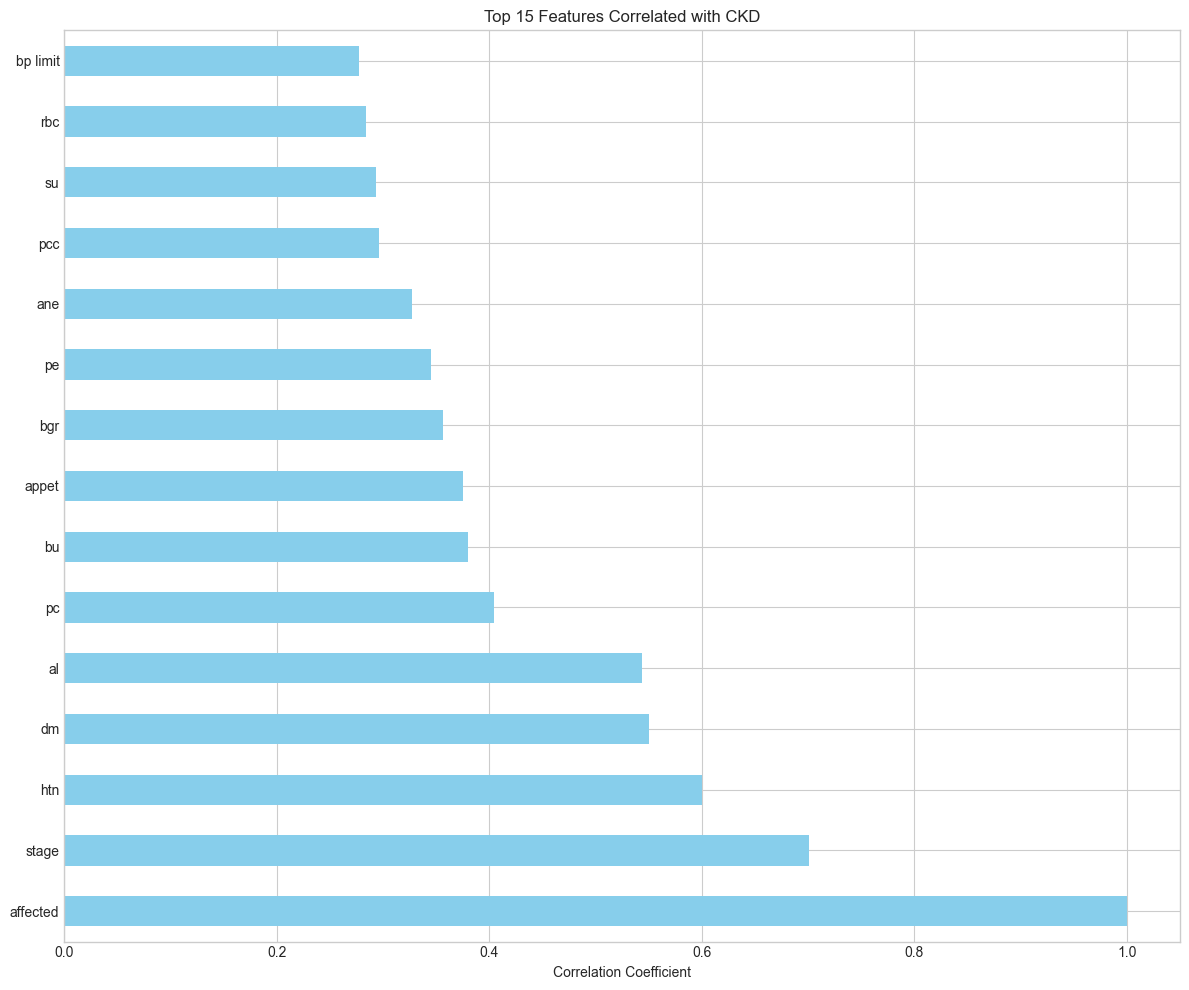

In [8]:
# Visualize top correlations with target
plt.figure(figsize=(12, 10))
top_corr = corr_with_target.drop('target')  # Drop self-correlation
top_corr = top_corr.head(15)  # Top 15 correlations
top_corr.plot(kind='barh', color='skyblue')
plt.title('Top 15 Features Correlated with CKD')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.savefig('top_features_correlation.png')
plt.show()

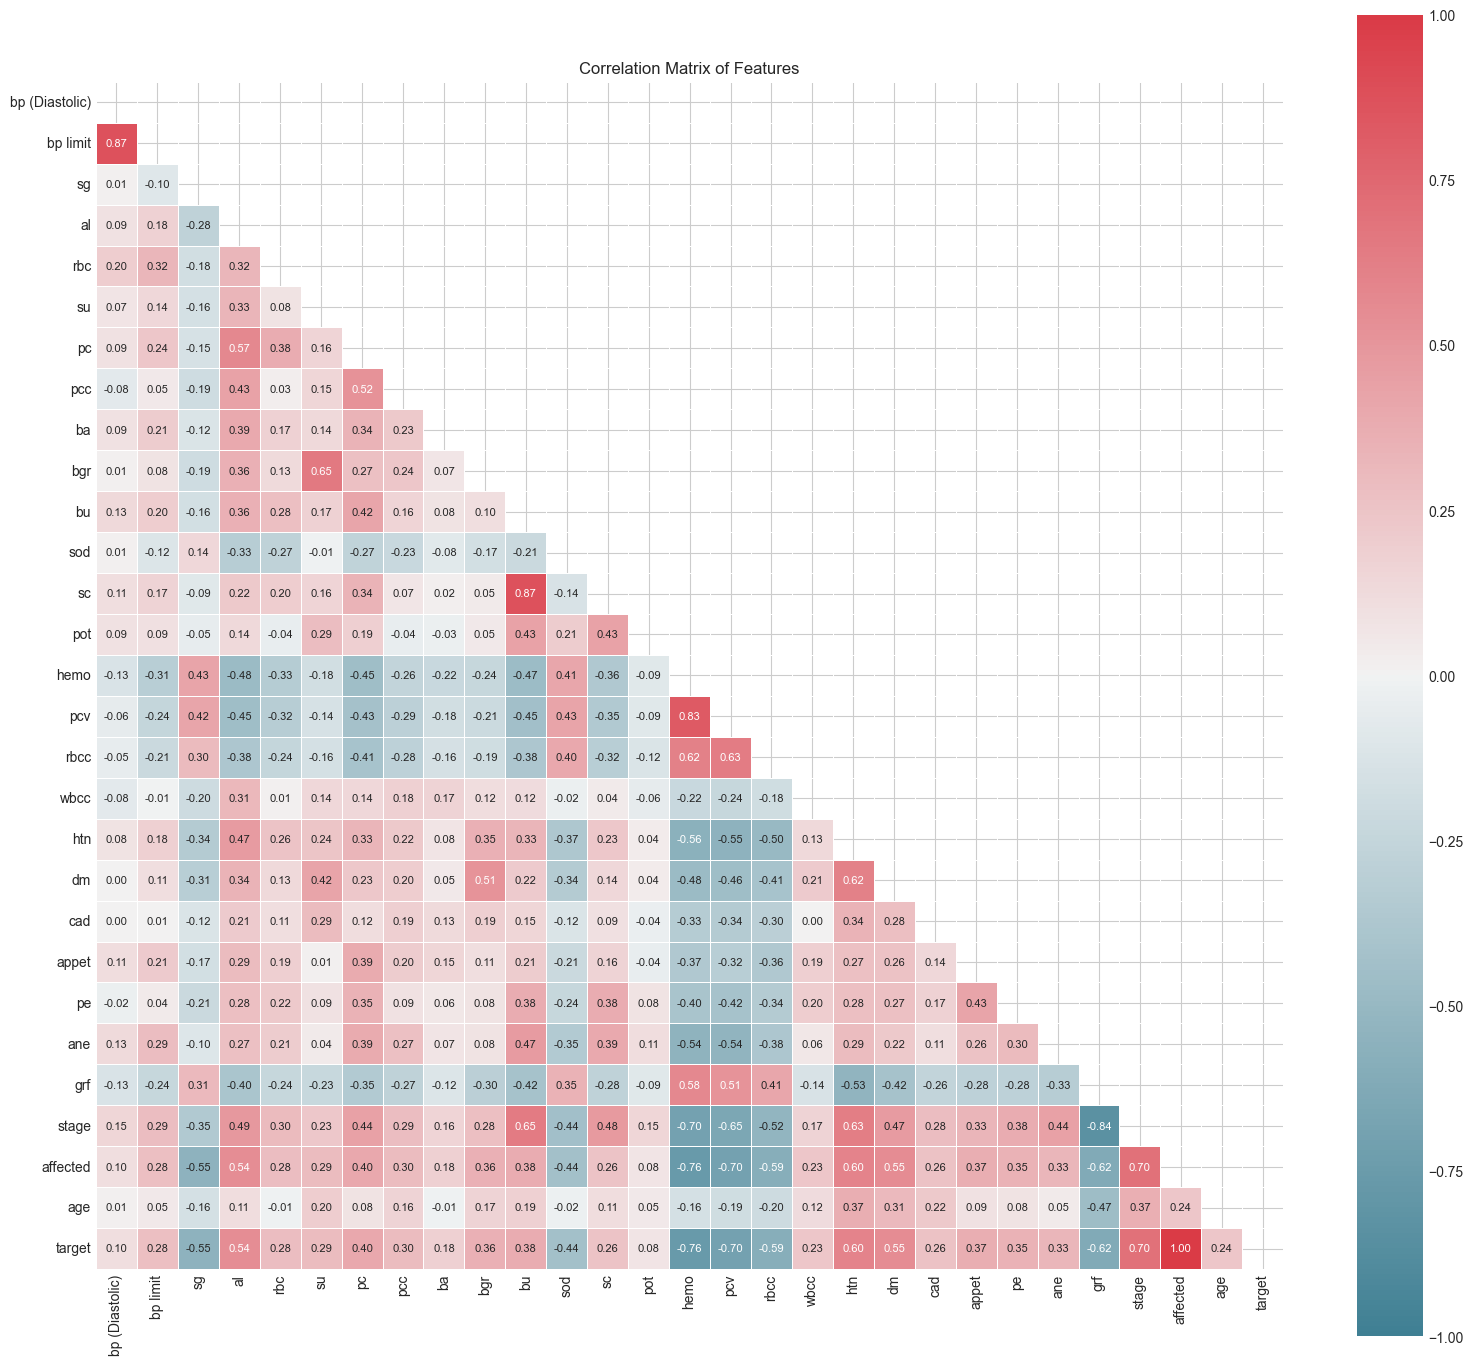

In [9]:
# Create correlation heatmap
plt.figure(figsize=(16, 14))
corr_matrix = df_processed[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
           square=True, linewidths=.5, annot=True, fmt='.2f', annot_kws={'size': 8})
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

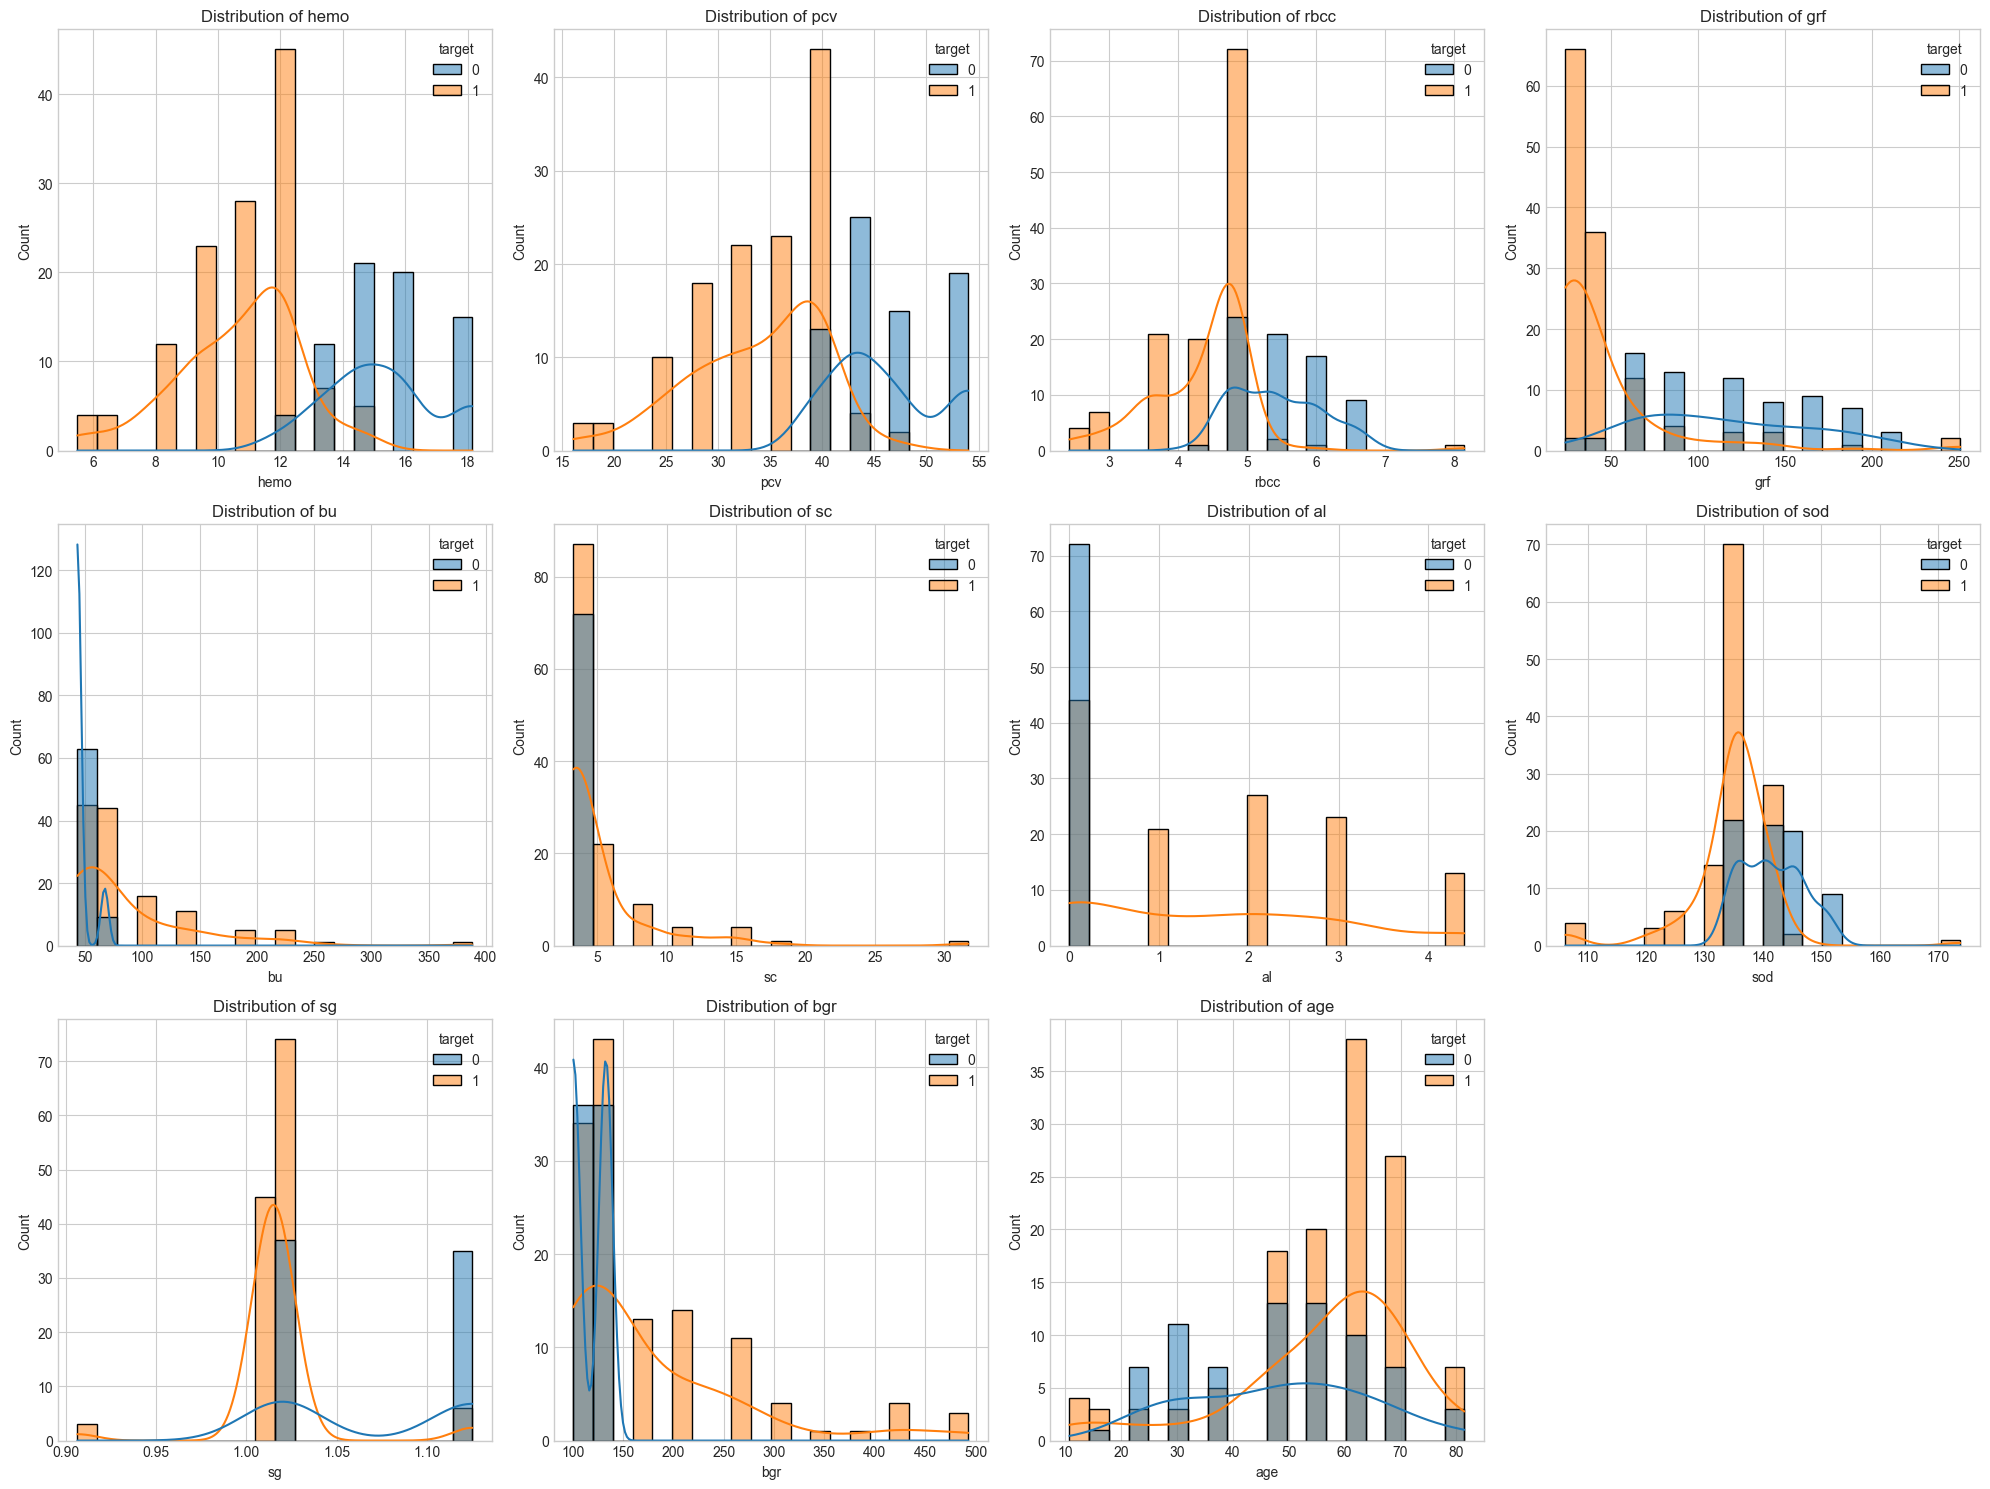

In [10]:
# Create histograms for numeric features
numeric_features = ['hemo', 'pcv', 'rbcc', 'grf', 'bu', 'sc', 'al', 'sod', 'sg', 'bgr', 'age']
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data=df_processed, x=feature, hue='target', kde=True, bins=20)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()

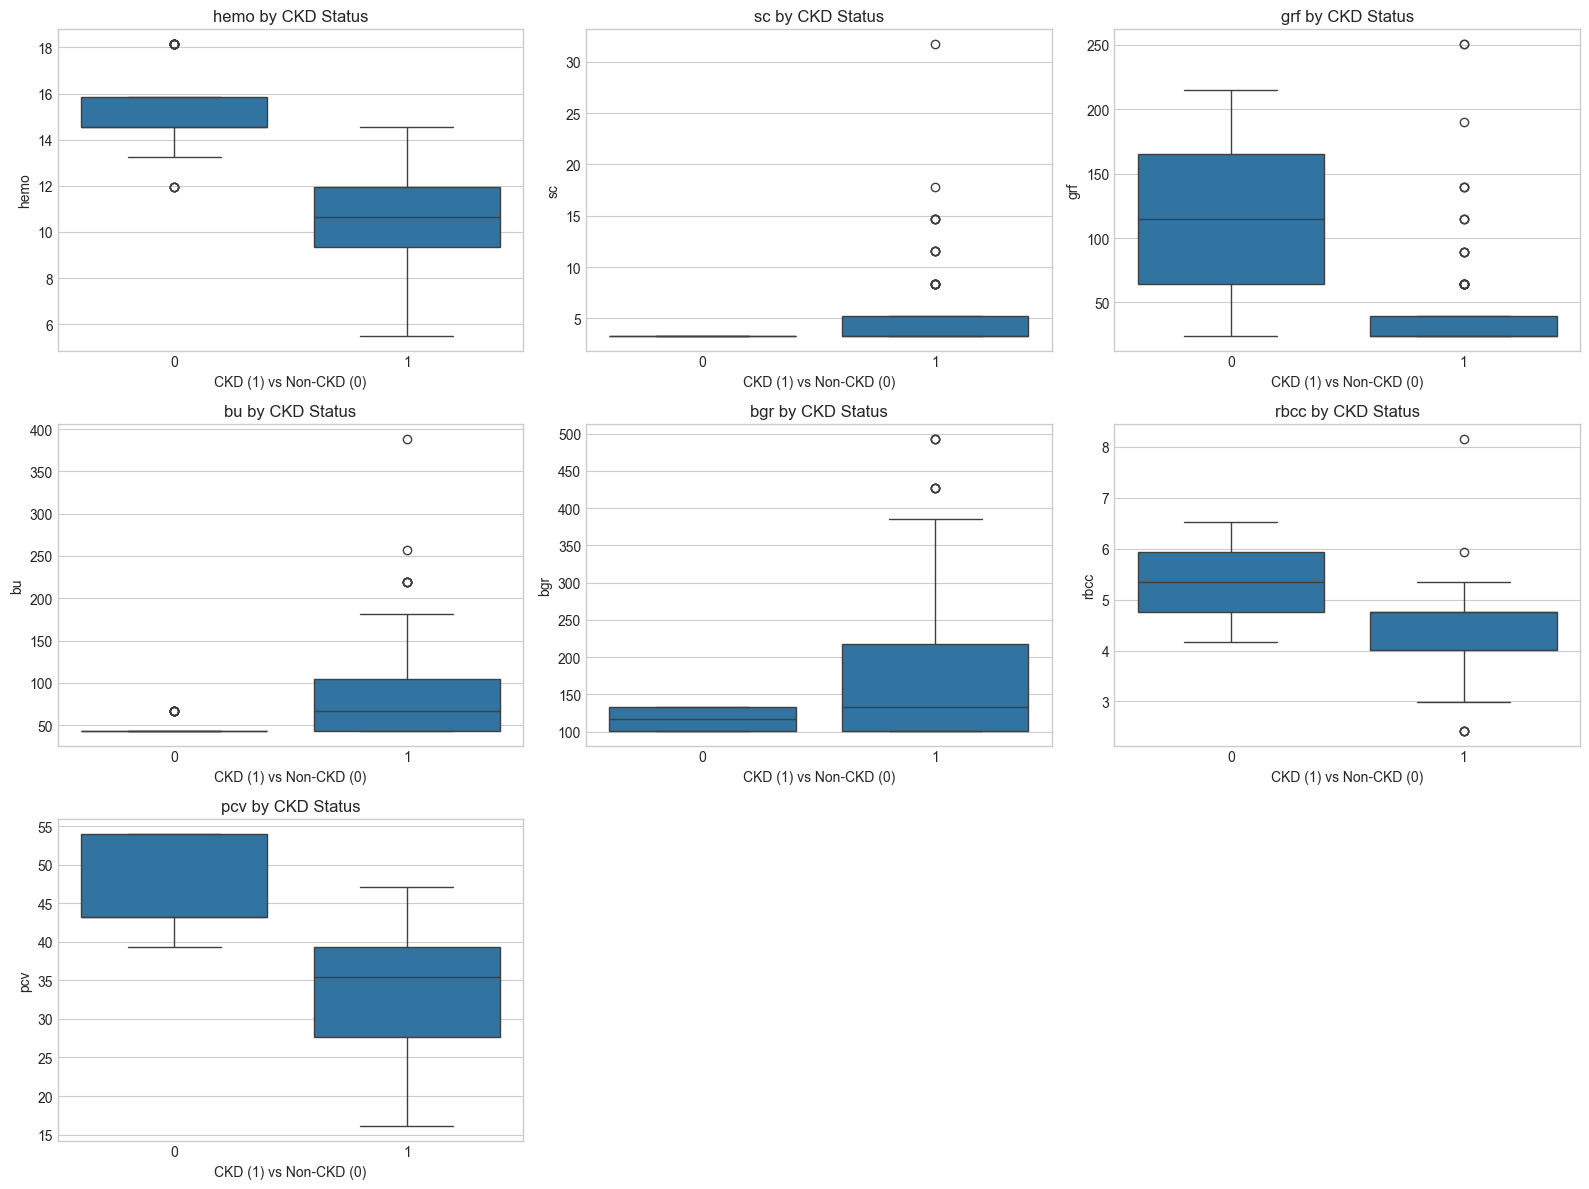

In [11]:
# Create boxplots for key features by CKD status
important_features = ['hemo', 'sc', 'grf', 'bu', 'bgr', 'rbcc', 'pcv']  
plt.figure(figsize=(16, 12))
for i, feature in enumerate(important_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='target', y=feature, data=df_processed)
    plt.title(f'{feature} by CKD Status')
    plt.xlabel('CKD (1) vs Non-CKD (0)')
plt.tight_layout()
plt.savefig('boxplots_by_ckd_status.png')
plt.show()

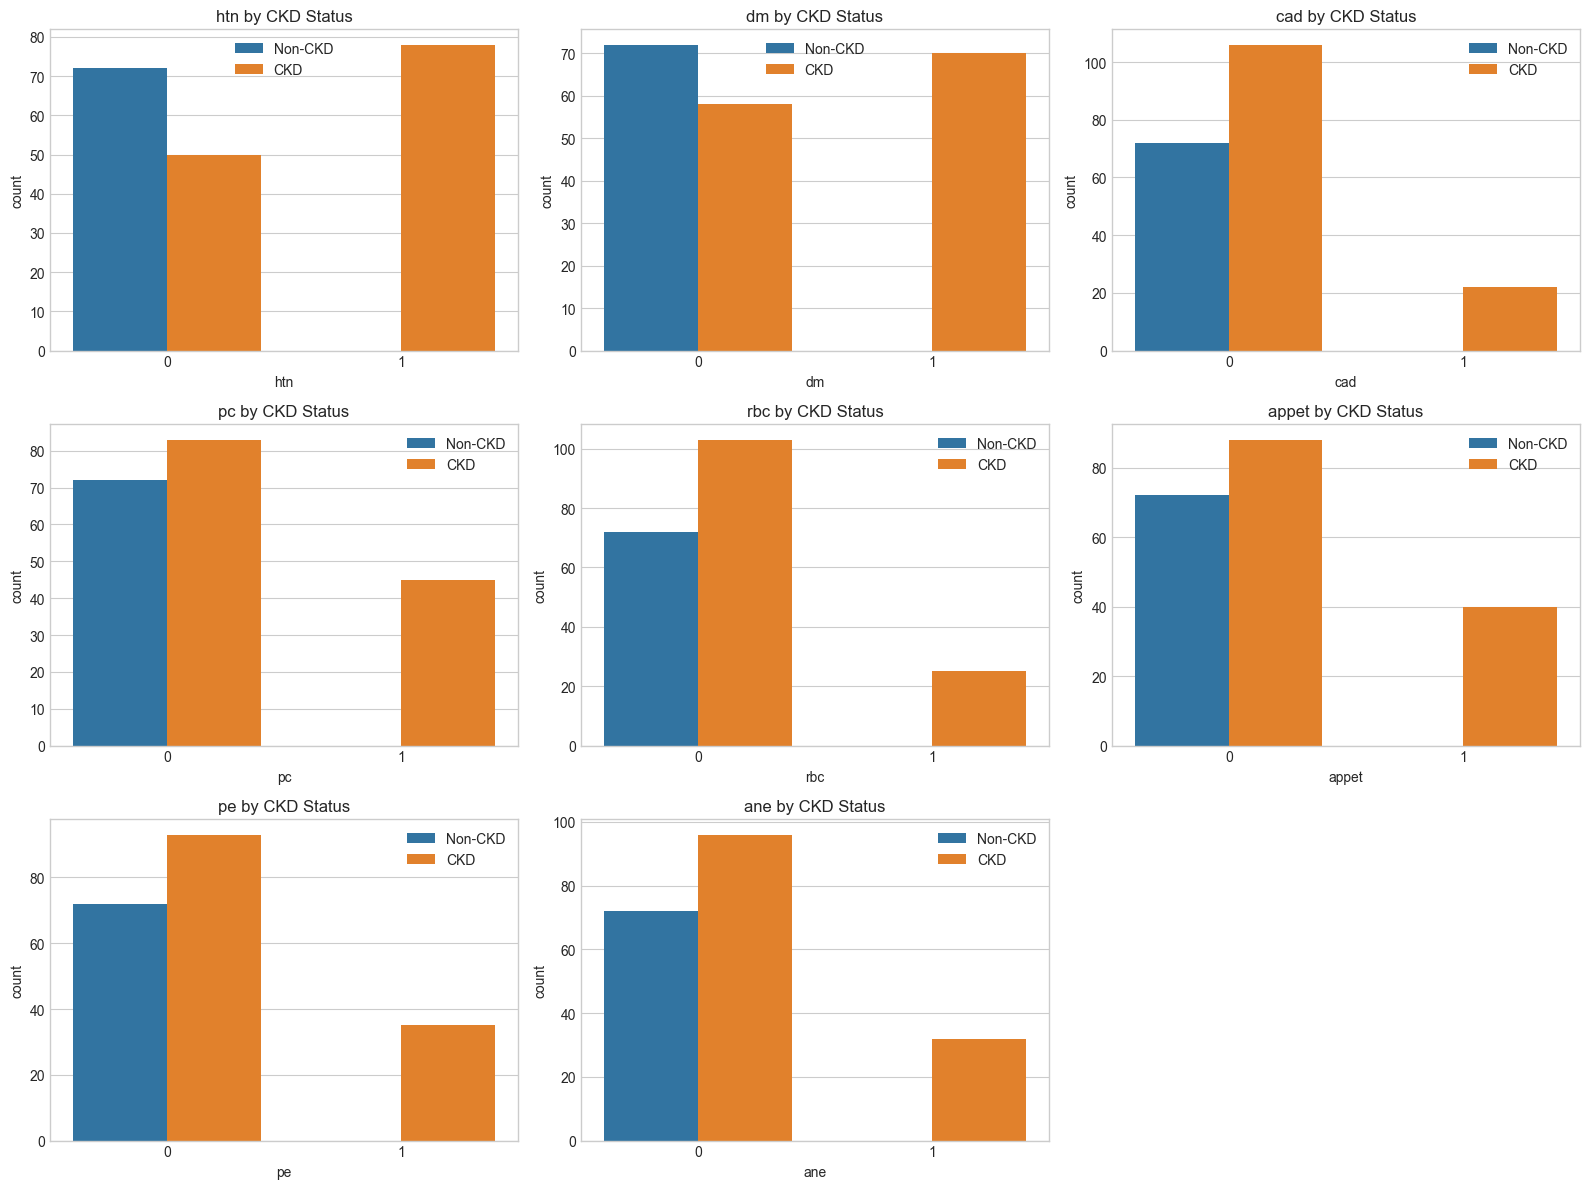

In [12]:
# Visualize binary features
binary_features = ['htn', 'dm', 'cad', 'pc', 'rbc', 'appet', 'pe', 'ane']
plt.figure(figsize=(16, 12))
for i, feature in enumerate(binary_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=feature, hue='target', data=df_processed)
    plt.title(f'{feature} by CKD Status')
    plt.legend(['Non-CKD', 'CKD'])
plt.tight_layout()
plt.savefig('binary_features_by_ckd.png')
plt.show()

In [13]:
# Select features based on correlation and domain knowledge
selected_features = [
    'hemo', 'pcv', 'rbcc', 'grf', 'bu', 'sc', 'al', 'sod', 'sg',
    'htn', 'dm', 'cad', 'pc', 'rbc', 'su', 'appet', 'pe', 'ane', 'age'
]

print("\nSelected features for modeling:")
print(selected_features)


Selected features for modeling:
['hemo', 'pcv', 'rbcc', 'grf', 'bu', 'sc', 'al', 'sod', 'sg', 'htn', 'dm', 'cad', 'pc', 'rbc', 'su', 'appet', 'pe', 'ane', 'age']


In [14]:
# Create final dataset for modeling
X = df_processed[selected_features]
y = df_processed['target']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (160, 19)
Test set shape: (40, 19)


In [15]:
# Create preprocessing pipeline
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Fit preprocessor on training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("\nProcessed training set shape:", X_train_processed.shape)
print("Processed test set shape:", X_test_processed.shape)

# Save preprocessed data for modeling (optional)
np.save('X_train_processed.npy', X_train_processed)
np.save('X_test_processed.npy', X_test_processed)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

print("\nEDA and preprocessing completed!")


Processed training set shape: (160, 19)
Processed test set shape: (40, 19)

EDA and preprocessing completed!
